In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle
# from glob import glob
# import random
# import itertools
from tqdm import tqdm
from time import time

from utils import get_image_filepaths

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


In [3]:
img_size = 128

batch_size = 2
valid_batch_size = 2
epochs = 15
n_print = 200
lr = 0.001

workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "results/U2Net"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)

Device: cuda:0


In [4]:
from typing import List
import os

# Dataset

In [5]:
format = '.png'

train_path = "data/train/train"
test_path = "data/train/test"

img_train_paths = get_image_filepaths(os.path.join(train_path, "images"), format, as_mask=False)
img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), format, as_mask=False)

msk_train_paths = get_image_filepaths(os.path.join(train_path, "masks"), format, as_mask=True)
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), format, as_mask=True)

len(img_train_paths), len(msk_test_paths)

(3475, 625)

In [7]:
img_train_paths[:5], msk_train_paths[:5]

(['data/train/train/images/2662.png',
  'data/train/train/images/1045.png',
  'data/train/train/images/1445.png',
  'data/train/train/images/3274.png',
  'data/train/train/images/0413.png'],
 ['data/train/train/masks/2662.png',
  'data/train/train/masks/1045.png',
  'data/train/train/masks/1445.png',
  'data/train/train/masks/3274.png',
  'data/train/train/masks/0413.png'])

Already numpy.array
Already numpy.array


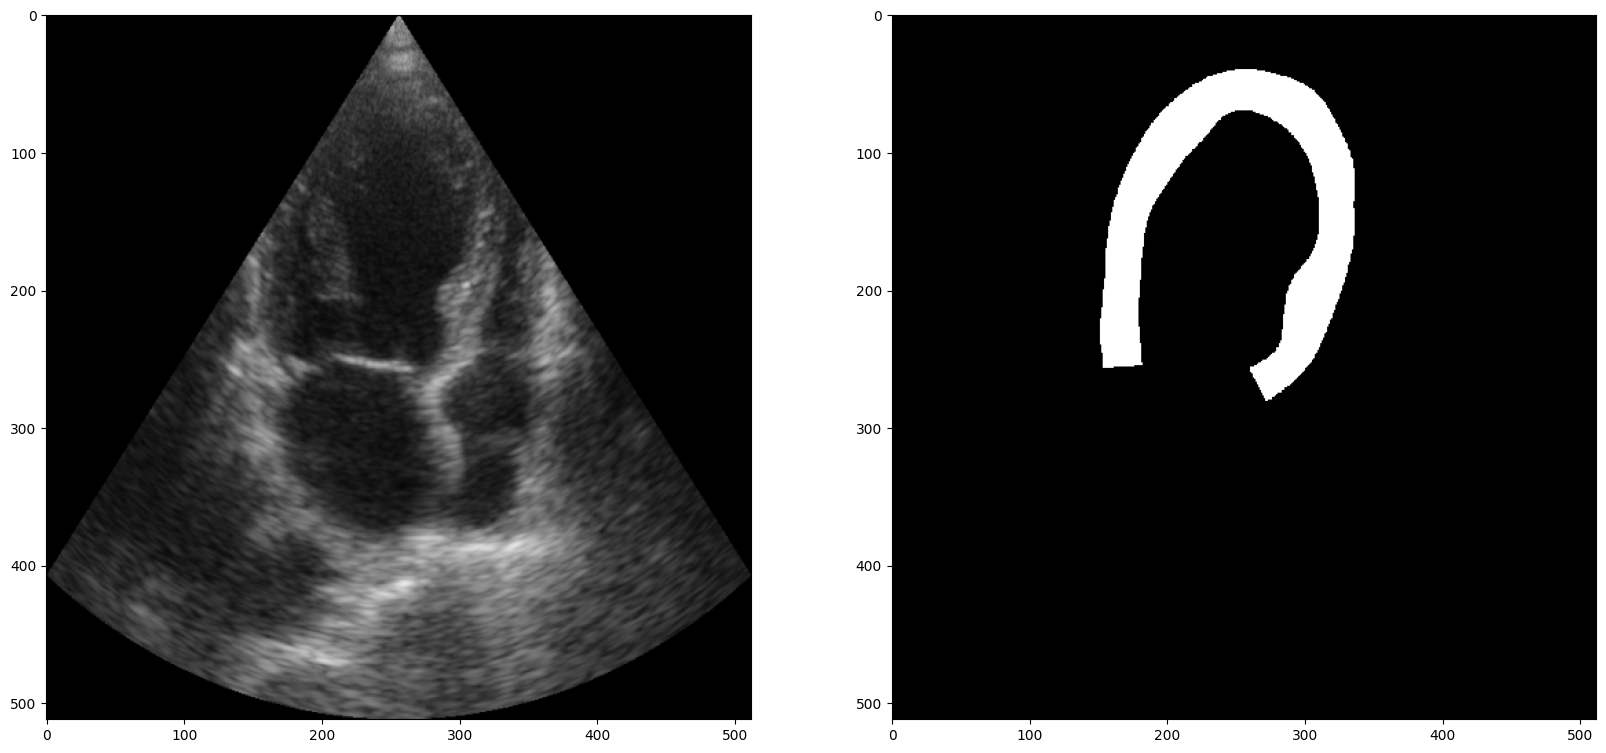

In [8]:
from src.scripts.DataLoaders import HeartLoader, ImgForPlot

# transform = transforms.Compose([transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
dataset = HeartLoader(img_train_paths, msk_train_paths, image_size=(512, 512))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

valid_dataset = HeartLoader(img_test_paths, msk_test_paths, image_size=(512, 512))
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=workers)
     
im, m = dataset[777]

fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

In [10]:
# mean = torch.tensor([0.485, 0.456, 0.406])
# std = torch.tensor([0.229, 0.224, 0.225])
 
# resize_shape = (320,320)
 
# transforms = T.Compose([T.ToTensor(),
#                         T.Normalize(mean=mean, std=std)])

In [11]:
# def prepare_image_batch(image_dir, resize, transforms, device):
 
#     image_batch = []
 
#     for image_file in os.listdir(image_dir):
#         image = Image.open(os.path.join(image_dir, image_file)).convert("RGB")
#         image_resize = image.resize(resize, resample = Image.BILINEAR)
     
#         image_trans = transforms(image_resize)
#         image_batch.append(image_trans)
     
     
#     image_batch = torch.stack(image_batch).to(device)
 
#     return image_batch
 
# image_batch = prepare_image_batch(image_dir="test_images",
#                                  resize=resize_shape,
#                                  transforms=transforms,
#                                  device="cuda:0")

# Model

In [12]:
from src.scripts.models.U2Net import U2Net

In [13]:
model_name = 'u2net-cardio_segmentation'
loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}_best.pt"

with open(loss_path, 'rb') as f:
  losses = pickle.load(f)


model = U2Net().to(device)
# Continue lerning
model.load_state_dict(torch.load(model_path))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# LOAD MODEL

model_name = 

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:

  losses = pickle.load(f)

model.load_state_dict(torch.load(model_path))
     


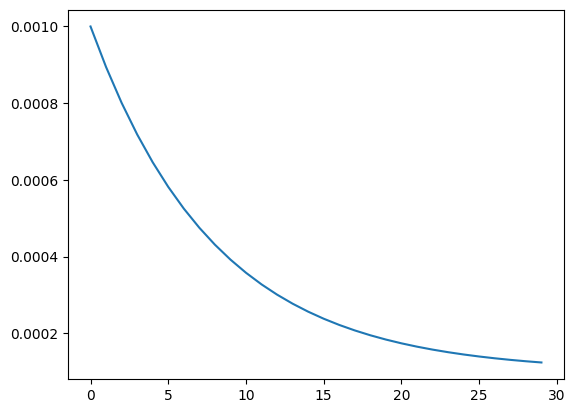

In [14]:
LR_START = 0.001
T_alpha = 7   # Time constant, чем меньше тем быстрее
LOW = 0.0002

def ws_lr(epoch, lr):
    return (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW

xx = np.arange(30)

plt.plot(xx, [ws_lr(x, 0.01) for x in xx])

In [15]:
import math


def update_lr(epoch, T):
  # Decrease lr every T epochs
  new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [16]:
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss


BCE = nn.BCELoss(reduction='mean')  # Train
MAE = nn.L1Loss(reduction='mean')   # Validation
# IoU_loss = IoULoss()
DICE =  DiceLoss()
DBCE = DiceBCELoss()

nvidia-settings -a GPUFanControlState=1 -a GPUTargetFanSpeed=60


We have 6 outputs from model, the last layer (out[-1]) is a final predict

In [1]:
version = 1


if version:
  loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
  best_model_path = F"{model_saved_dir}/{model_name}_best.pt"
  model_path = F"{model_saved_dir}/{model_name}.pt"
else: 
  loss_path = F"{model_saved_dir}/{model_name}_loss_{version}.txt"
  best_model_path = F"{model_saved_dir}/{model_name}_best_{version}.pt"
  model_path = F"{model_saved_dir}/{model_name}_{version}.pt"

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs):
    update_lr(ep, 4)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(dataloader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
        # loss = sum(each_loss)
        each_loss = [ DBCE(o, target) for o in out ]  
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(dataloader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(dataloader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()
      
    # Evaluate Model
    model.eval()
    step, loss_sum = 0, 0.
    timestamp = time()
    with torch.no_grad():
        for input, target in tqdm(valid_dataloader):
            out = model(input.to(device))[-1]
            if out.ndim == 3:
                out = out.unsqueeze(1)
            
            loss_sum += DICE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
            step += input.size(0)
      
        val_loss = loss_sum / step
        losses['valid'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

    torch.save(model.state_dict(), model_path)
    with open(loss_path, 'wb') as f:
        pickle.dump(losses, f)
    
    print("Saved model completely!")


NameError: name 'model_saved_dir' is not defined

In [1]:
import matplotlib


matplotlib.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(15,10))

N = len(losses['train'])
y = []
for i in range(N):
  y.append(sum([losses['train'][j][i] for j in range(6)]))

K = 25
avg = []
for i in range(K, N-K):
  avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
plt.plot(range(N), y, alpha=0.5)
plt.plot(range(K, N-K), avg, 'maroon')
plt.ylim(0, 4)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss (Binary Cross Entrophy)')
#plt.show()
# plt.savefig('train_loss.png')

NameError: name 'plt' is not defined

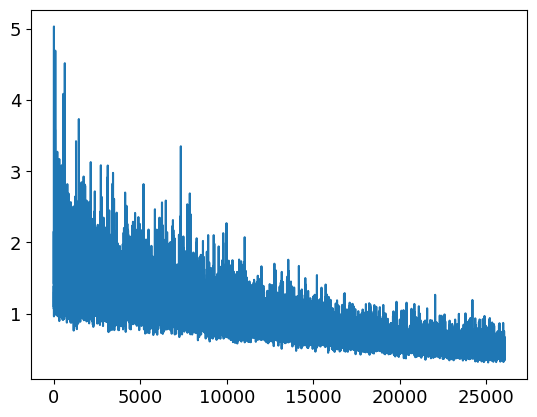

In [22]:
plt.plot(losses['train'])

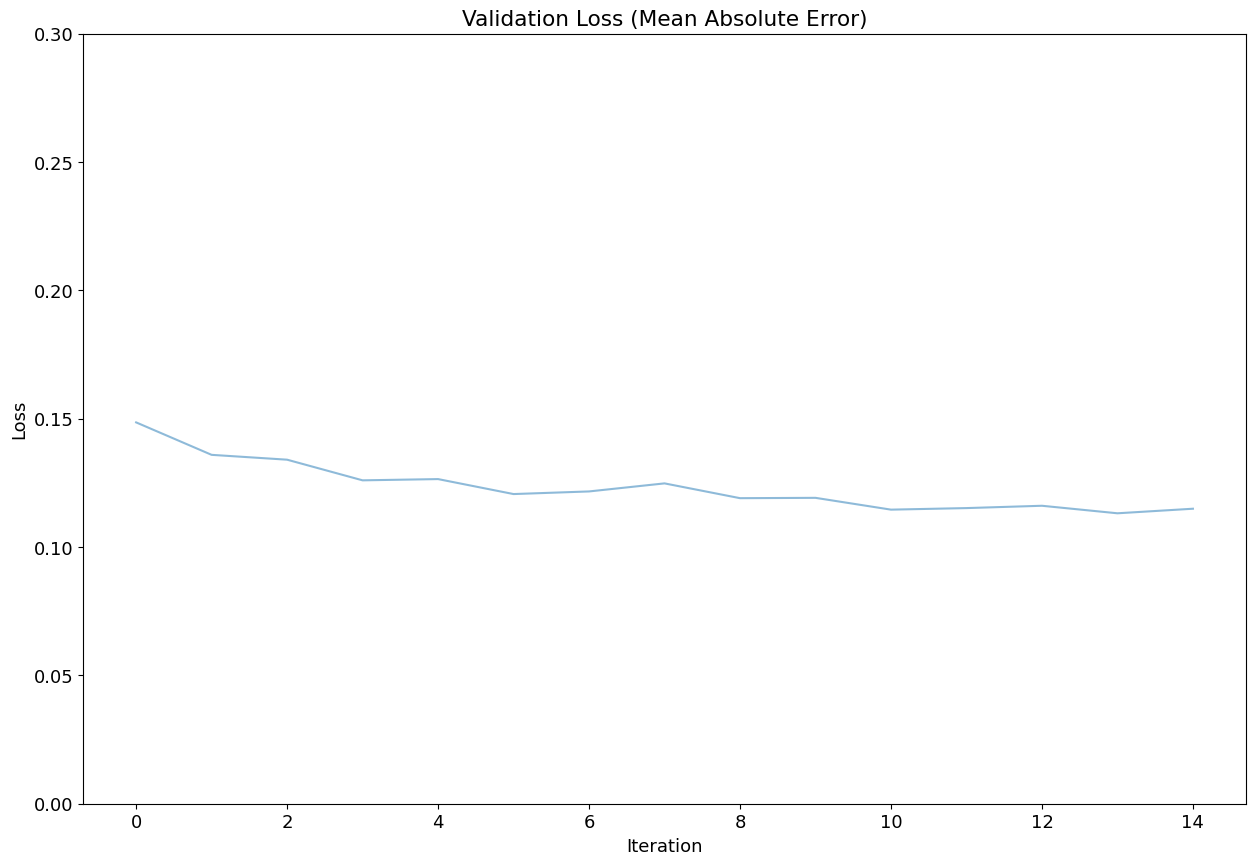

In [23]:
fig = plt.figure(figsize=(15,10))
y = losses['valid']
N = len(y)

K = 25
avg = []
for i in range(K, N-K):
  avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
plt.plot(range(N), y, alpha=0.5)
plt.plot(range(K, N-K), avg, 'maroon')
plt.ylim(0, 0.3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Validation Loss (Mean Absolute Error)')
#plt.show()
plt.savefig('val_loss.png')